# Finite Differenzen Methode

Wir betrachten das Randwertproblem
\begin{equation}\label{eq:exmprandwertproblem}\begin{split}
-u''(x) & = f(x)\quad\text{für}\ x\in (0,1)\\	
u(0) & = 0\\
u(1) & = 0.
\end{split}\end{equation}

Mit $f(x) = 1$

Die analytische Lösung folgt leicht mittels zweimaliges Integrieren
$$u(x) = -\frac{1}{2} x (x-1).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Numerische Lösung des Randwertproblems

In [2]:
# Rechteseite
def f(x):
    return np.ones_like(x)

# Randbedingungen
uR = 0
uL = 0

In [3]:
def uanalytisch(x):
    return -0.5*x*(x-1)

Diskretisierung des Intervall $[0,1]$ mit äquidistanten Stützpunkte

In [4]:
n = 5
x = np.linspace(0,1,n+1)
h = 1/n

In Matrixschreibweise folgt für das diskrete System (vgl. Skript)

$$\underbrace{\begin{pmatrix}
	2 & -1 & 0      & \ldots & 0 \\
	-1 & 2 & \ddots & \ddots & \vdots\\ 
	 0  & \ddots & \ddots &  & 0\\
	\vdots   &   \ddots    &  & 2 & -1 \\
	 0  &  \ldots    &   0 & -1 & 2 
\end{pmatrix}}_{\displaystyle = A}\cdot \underbrace{\begin{pmatrix}
	u_1\\ u_2\\\vdots\\u_{n-2} \\u_{n-1}
\end{pmatrix}}_{\displaystyle = u} = \underbrace{\begin{pmatrix}
	\Delta x^2 + u_0\\
	\Delta x^2\\
	\vdots\\
	\Delta x^2\\
	\Delta x^2 + u_n\\
\end{pmatrix}}_{\displaystyle = b}$$

Gesucht ist daher der Vektor $u$ des linearen Gleichungssystems
$$A\cdot u = b$$

In [5]:
A = np.diag(2*np.ones(n-1)) - np.diag(np.ones(n-2),1) - np.diag(np.ones(n-2),-1)

In [6]:
b = h**2*f(x[1:-1]) # die Funktion wird bei den inneren Punkte ausgewertet
b[0] += uL           # rechter Randwert
b[-1] += uR          # linker Randwert

In [7]:
# import lu decomposition from scipy
from scipy.linalg import lu, solve_triangular

In [8]:
P,L,R = lu(A,)

Wir lösen das faktorisierte Gleichungssystem durch Vor- / Rückwärtseinsetzen:
$$L\cdot \underbrace{R\cdot u}_{z} = P^T\cdot b$$
Daher lösen wir mittels Vorwärtseinsetzen zuerst die Gleichung
$$L\cdot z = P^T\cdot b$$
und danach mit Rückwärtseinsetzen
$$R\cdot u = z.$$

**Bemerkung:** Vorsicht im Skript benutzen wir $L\cdot R = P\cdot A$. Die Aussage ist, dass eine Permutationsmatrix $P$ existiert so, dass $P\cdot A = L\cdot R$ gilt. `Numpy` und `Scipy` liefern jedoch $A = P\cdot L\cdot R$, wobei jeweilen $P$ bis auf das transponierte identisch sind.

Die Matrixmultiplikation der Permutation kann vermieden werden:

In [9]:
ind = []
for i in range(n-1):
    j = 0
    while P[j,i] == 0:
        j += 1
    ind.append(j)
ind = np.array(ind)

Damit haben wir die Reihenfolge der Zeilen im Vektor ind gespeichert.

Vorwärtseinsetzen:

In [10]:
z = solve_triangular(L,b[ind],lower=True)

Rückwärtseinsetzen:

In [11]:
u = np.zeros_like(x)
u[0] = uL
u[-1] = uR
u[1:-1] = solve_triangular(R,z)

Visualisierung der Lösung

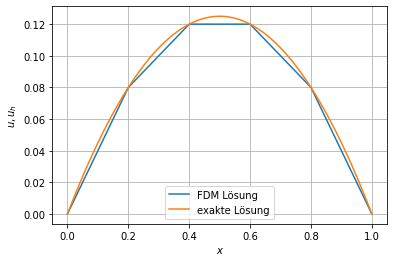

In [12]:
plt.plot(x,u,label='FDM Lösung')
xp = np.linspace(0,1,300)
plt.plot(xp, uanalytisch(xp), label='exakte Lösung')
plt.xlabel('$x$')
plt.ylabel('$u,u_h$')
plt.legend()
plt.grid()
plt.show()

Das Ergebniss lässt sich selber bei nur fünf Intervalle sehen.

## Konvergenz

Um die Konvergenz zu diskutieren packen wir alles in eine Funktion.

In [13]:
def fdmLoeser(n):
    x = np.linspace(0,1,n+1)
    h = 1/n
    A = np.diag(2*np.ones(n-1)) - np.diag(np.ones(n-2),1) - np.diag(np.ones(n-2),-1)
    b = h**2*f(x[1:-1]) # die Funktion wird bei den inneren Punkte ausgewertet
    b[0] += uL           # rechter Randwert
    b[-1] += uR          # linker Randwert
    P,L,R = lu(A,)
    ind = []
    for i in range(n-1):
        j = 0
        while P[j,i] == 0:
            j += 1
        ind.append(j)
    ind = np.array(ind)
    z = solve_triangular(L,b[ind],lower=True)
    u = np.zeros_like(x)
    u[0] = uL
    u[-1] = uR
    u[1:-1] = solve_triangular(R,z)
    return x,u

In [14]:
err = []
h = []
for n in 10**np.arange(1,5):
    x,u = fdmLoeser(n)
    h.append(1/n)
    err.append(np.linalg.norm(u-uanalytisch(x),ord=np.inf))
err = np.array(err)
h = np.array(h)

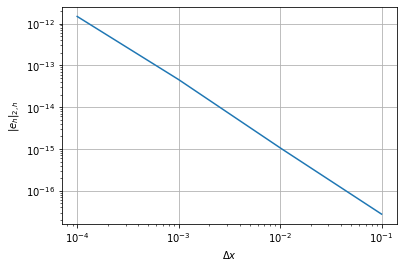

In [15]:
plt.loglog(h,err)
plt.grid()
plt.xlabel('$\Delta x$')
plt.ylabel('$\|e_h\|_{2,h}$')
plt.show()

Für das Beispiel können wir eine interessante Eigenschaft der Gleichung beobachten, auf die wir später eingehen: In diesem Beispiel liefert die FDM unabhängig von der Schrittweite die exakte Lösung! Dass der Fehler zunimmt liegt am numerischen Rundungsfehler, welche in dem Fall für den Fehler verantwortlich sind.

### Weiteres Beispiel

Um eine vernünftige Konvergenzordnung beobachten zu können, wählen wir eine andere rechte Seite $f(x)$ der Differentialgleichung. Sei $f(x)$ gegeben durch

$$f(x) = \sin(2\pi x)^2.$$

In [16]:
def f(x):
    return np.sin(2*np.pi*x)**2

Mittels Integration können wir wiederum die exakte Lösung analytisch berechnen.

In [17]:
def uanalytisch(x):
    return (1 + 8*np.pi**2*x - 8*np.pi**2*x**2 - np.cos(4*np.pi*x))/(32.*np.pi**2)

In [18]:
err = []
h = []
for n in 10**np.arange(1,4):
    x,u = fdmLoeser(n)
    h.append(1/n)
    err.append(np.linalg.norm(u-uanalytisch(x),ord=np.inf))
err = np.array(err)
h = np.array(h)

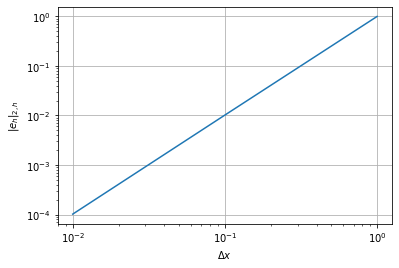

In [19]:
plt.loglog(h/h[0],err/err[0])
plt.grid()
plt.xlabel('$\Delta x$')
plt.ylabel('$\|e_h\|_{2,h}$')
plt.show()

Es kann gezeigt werden, dass unter der Voraussetzung $u(x)\in C^4([0,1])$

$$\|e_h\|_{2,h} \le \frac{1}{48} C h^2$$

gilt, wobei

$$C = \|u^{(4)}(x)\|_{\infty}.$$

Der Fehler geht daher quadratisch gegen 0 für $\Delta x \to 0$, wie wir im Beispiel beobachten können.